In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [9]:
# Load dataset
df = pd.read_csv('Electric_Production.csv', parse_dates=['DATE'],index_col='DATE')
df.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)

ValueError: Missing column provided to 'parse_dates': 'YEAR'

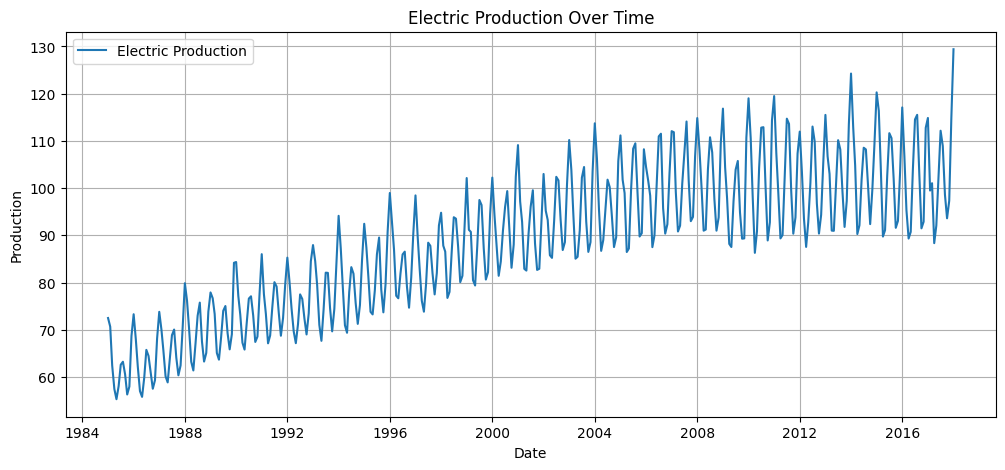

In [32]:
# Plot raw data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Electric_Production'], label='Electric Production')
plt.title('Electric Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
# Feature Engineering: Lag, Rolling, Expanding
df['Lag_1'] = df['Electric_Production'].shift(1)
df['Rolling_Mean_12'] = df['Electric_Production'].rolling(window=12).mean()
df['Expanding_Mean'] = df['Electric_Production'].expanding().mean()

In [34]:
df
# Bhai ye jo NaN values aa rahi hain rolling mean ke start me, uski reason bahut simple hai:"12 mahine ka moving average 
# lo" — lekin jab tak 12 data points na ho jaayein, tab tak wo mean calculate kar hi nahi sakta, isliye NaN deta hai.

,Electric_Production,Lag_1,Rolling_Mean_12,Expanding_Mean
DATE,,,,
1985-01-01,72.5052,NaN,NaN,72.505200
1985-02-01,70.6720,72.5052,NaN,71.588600
1985-03-01,62.4502,70.6720,NaN,68.542467
1985-04-01,57.4714,62.4502,NaN,65.774700
1985-05-01,55.3151,57.4714,NaN,63.682780
...,...,...,...,...
2017-09-01,98.6154,108.9312,101.234450,88.644452
2017-10-01,93.6137,98.6154,101.411700,88.657065
2017-11-01,97.3359,93.6137,101.782192,88.679036


In [35]:
# Check for the stationary usinf ADF Test
def adf_test(df):
    result = adfuller(df)
    print("ADF Statistic:", result[0])
    print("p-values:", result[1])
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is not Stationary")

In [36]:
adf_test(df['Electric_Production'])

ADF Statistic: -2.25699035004725
p-values: 0.18621469116586592
Data is not Stationary


In [47]:
# Differencing to remove trend and seasonality if there is seasonality
df['Electric_Production_diff'] = df['Electric_Production'].diff().dropna()
df['Electric_Production_seasonal_diff'] = df['Electric_Production'].diff(12).dropna()

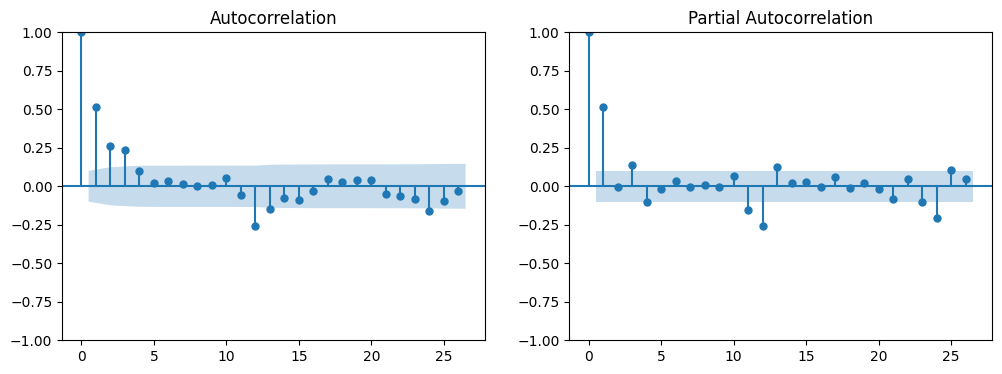

In [48]:
# plot ACF and PACF to identify parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Electric_Production_seasonal_diff'].dropna(), ax=axes[0])
plot_pacf(df['Electric_Production_seasonal_diff'].dropna(), ax=axes[1])
plt.show()

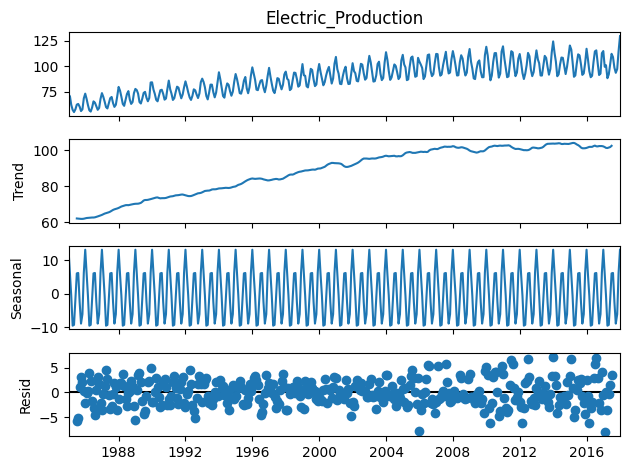

In [38]:
# Decomposition
decomposition = seasonal_decompose(df['Electric_Production'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

In [39]:
# Differencing
# First order
df['Diff_1'] = df['Electric_Production'].diff()
# Seasonal differencing
df['Seasonal_Diff_12'] = df['Electric_Production'].diff(12)

In [40]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df['Electric_Production'][0:train_size], df['Electric_Production'][train_size:]

In [41]:
#walk forward validation
history = train.tolist()
predictions = []
for t in test:
    model = AutoReg(history, lags = 7)
    model_fit = model.fit()
    
    y_pred = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(y_pred)
    
    history.append(t)

In [42]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Walk-Forward Validation RMSE: {rmse:.4f}')

Walk-Forward Validation RMSE: 4.5878


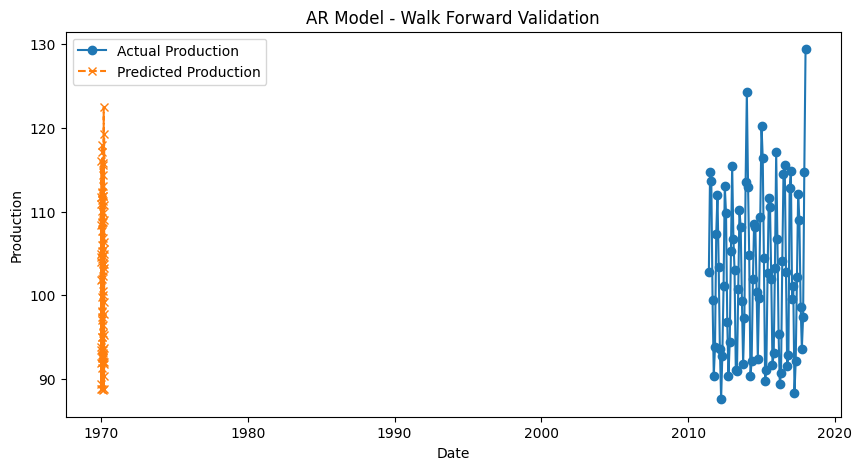

In [44]:
# plot actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test, label='Actual Production', marker='o')
plt.plot(predictions, label='Predicted Production', marker='x', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('AR Model - Walk Forward Validation')
plt.legend()
plt.show()

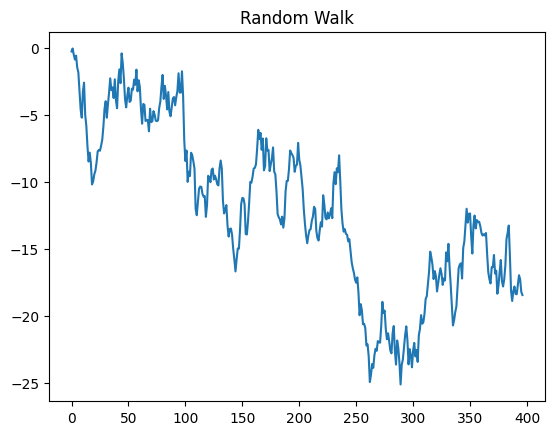

In [45]:
# Random walk
random_walk = np.random.normal(0, 1, len(df)).cumsum()
plt.plot(random_walk)
plt.title('Random Walk')
plt.show()

In [12]:
# AR model
model_ar = AutoReg(train, lags=12).fit()
predictions = model_ar.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

D:\anconda\envs\notebook-6.5.7\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\anconda\envs\notebook-6.5.7\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


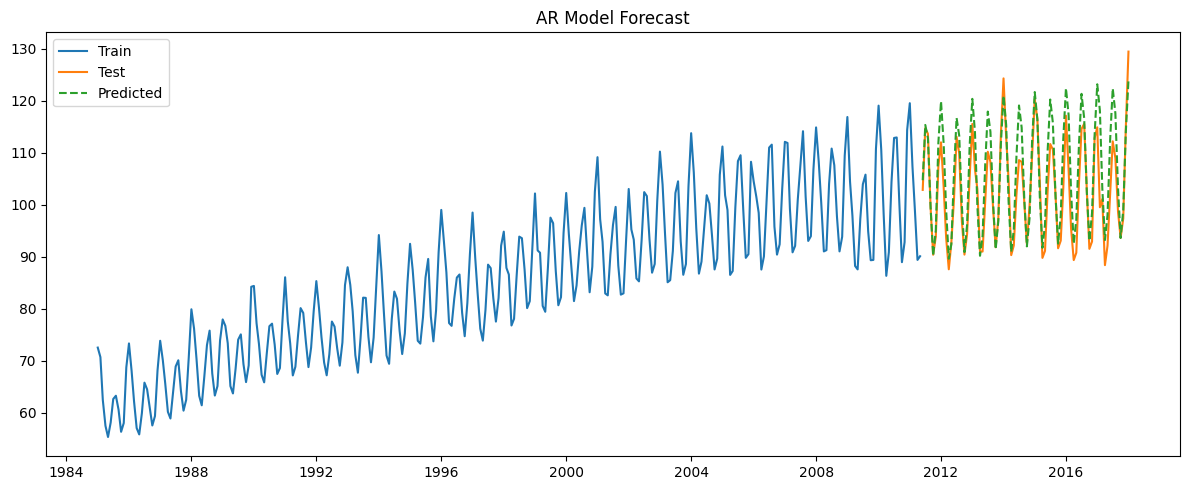

In [ ]:
# Forecast plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title('AR Model Forecast')
plt.tight_layout()
plt.show()
print("Project Submitted by nakul")